# Expanding Example Set

Using the train.csv set from MNIST, describing 42000 handwritten digits, we tried to expand our dataset.

1. We loaded the train.csv and transformed the 1D data into 2D 28x28 NumPy arrays.
2. We created SimpleCV Image objects from the arrays and scaled them to be 32x32 pixels.
3. We extracted the same features as our v4 dataset and joined them.

After thorough testing we, sadly, came to the conclusion the digits were too different for the features we extracted. Accuracy dropped to less than `.25`. It may have worked if we just used the pixel count and number of holes features.

In [1]:
# IMPORTS AND NOTEBOOK SETUP
from SimpleCV import *
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

# Config: size of the figures
matplotlib.rcParams['figure.figsize'] = [10, 6]

disp = Display(displaytype='notebook')

SIZE = 32

In [2]:
# Read digit data from csv
train = genfromtxt('train.csv', delimiter=',')
# Remove header
train = train[1:]

In [3]:
# Splitting labels and image data
print len(train)
labels = np.int_(train[:,0])
# Reshaping 1D data to 2D data
data = train[:,1:].reshape(-1, 28, 28)

42000


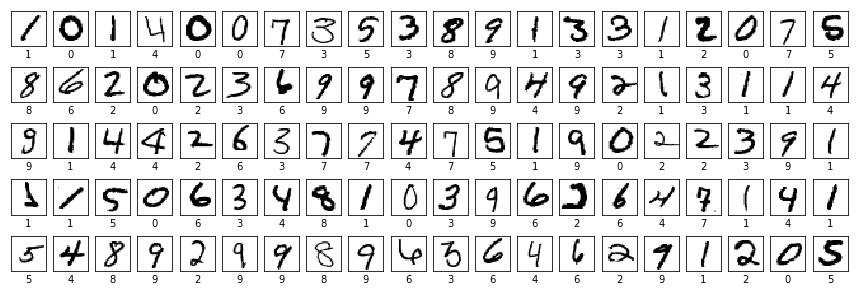

In [4]:
# PLOTTING DATA AND THEIR LABELS
PLOT_SIZE = 100
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(labels[i])
    plt.imshow(data[i], cmap=plt.cm.binary)

# Save sample to an image
# plt.savefig('digits_sample', dpi=200, bbox_inches='tight')

In [5]:
# Convert NumPy array to SimpleCV image objects
images = []
for image, label in zip(data, labels):
    imageObj = Image(image.T).resize(32, 32).binarize().invert()
    images.append((label, imageObj, imageObj))

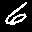

In [6]:
images[21][1].save(disp)

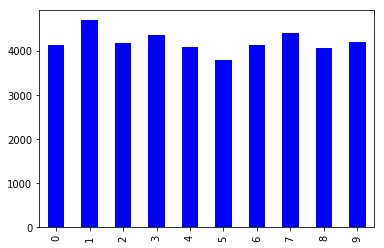

In [7]:
# CREATE DATAFRAME FROM DIGITS
columns = ['digit', 'image', 'image_raw']
data_unsorted = pd.DataFrame(images, columns=columns)
data_sorted = pd.DataFrame(sorted(images), columns=columns)

# PLOT INTERESTING FEATURES
digit_counts = data_unsorted.digit.value_counts()
digit_counts.sort_index(inplace=True)
digit_counts.plot(kind='bar')

Low-Res Pixel Count Matrix based on binarized image


/usr/local/lib/python2.7/dist-packages/SimpleCV/ImageClass.py:1970: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._numpy != "":


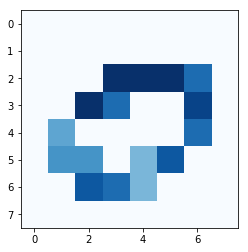

In [8]:
# WEIGHTED MATRIX CREATION
def get_weighted_matrix(img):
    COUNT = 8 # GRID SIZE
    T = 5 # THRESHOLD
    CROP = SIZE / COUNT
    m = np.zeros((COUNT, COUNT))
    for y in range(COUNT):
        for x in range(COUNT):
            part = img.crop(x * CROP, y * CROP, CROP, CROP)
            sum = (part.getNumpy()[:,:,0] / 255).sum()
            m[x][y] = sum if sum > T else 0
    return m.T

img = data_sorted.image[0]

m = get_weighted_matrix(img)
print 'Low-Res Pixel Count Matrix based on binarized image'
plt.imshow(m, cmap='Blues', interpolation='nearest')
plt.show()

In [22]:
# CREATING DICTIONARY TO SAVE ALL FEATURES IN

# Columns detected using computer vision
features_dict = {
    "area": [],
    "contours": [],
    "radius": [],
    "hull_radius": [],
    "centroid_x": [],
    "centroid_y": [],
    "num_holes": [],
    "label": []
}

# Adding column names for the low-res pixel count matrix
COUNT = 8
for x in range(COUNT):
    for y in range(COUNT):
        features_dict['_'.join(['weight', str(x), str(y)])] = []

In [23]:
# Iterate through rows of the DataFrame
for row in data_unsorted.iterrows():
    # HACK TO FIND BLOBS
    row[1][1].show()
    # Find blobs in the preprocessed image
    blobs = row[1][1].findBlobs()
    if blobs:
        blob = blobs[0]
        features_dict['area'].append(blob.area())
        features_dict['contours'].append(len(blob.contour()))
        features_dict['radius'].append(blob.radius())
        features_dict['hull_radius'].append(blob.hullRadius())
        features_dict['centroid_x'].append(blob.centroid()[0])
        features_dict['centroid_y'].append(blob.centroid()[1])

        # Calculate matrix in the preprocessed image
        m = get_weighted_matrix(row[1][1])
        COUNT = 8
        for x in range(COUNT):
            for y in range(COUNT):
                features_dict['_'.join(['weight', str(x), str(y)])].append(m[x, y])

        # Find the holes in the 'just binarized' image
        num_holes = len(row[1][2].embiggen(2).invert().findBlobs()[:-1])
        features_dict['num_holes'].append(num_holes)

        # Attach the correct label
        features_dict['label'].append(row[1][0])

# Create dataframe
data_frame = pd.DataFrame(features_dict)

In [24]:
print len(features_dict['area'])
print len(features_dict['contours'])
print len(features_dict['radius'])
print len(features_dict['hull_radius'])
print len(features_dict['centroid_x'])
print len(features_dict['centroid_y'])
print len(features_dict['num_holes'])
print len(features_dict['label'])

41998
41998
41998
41998
41998
41998
41998
41998


In [25]:
# Reorder columns
column_order = [
    "area",
    "contours",
    "radius",
    "hull_radius",
    "centroid_x",
    "centroid_y",
]

COUNT = 8
for x in range(COUNT):
    for y in range(COUNT):
        column_order.append('_'.join(['weight', str(x), str(y)]))
column_order.append("num_holes")
column_order.append("label")

data_frame = data_frame[column_order]

In [30]:
# Clean pixel counts too close to 0
data_clean = data_frame.copy()
means = data_clean.mean()
data_clean = data_clean.drop(means[means < .015].index, axis=1)
data_clean.describe()

,area,contours,radius,hull_radius,centroid_x,centroid_y,weight_0_0,weight_0_1,weight_0_2,weight_0_3,...,weight_7_0,weight_7_1,weight_7_2,weight_7_3,weight_7_4,weight_7_5,weight_7_6,weight_7_7,num_holes,label
count,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998,41998,41998.000000,41998.000000,...,41998,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998.000000,41998,41998.000000,41998.000000
mean,130.065515,38.106005,7.884814,10.212555,16.114101,16.114185,0,0,0.003429,0.017572,...,0,0.005000,0.151650,0.418568,0.276561,0.075813,0.003095,0,0.297705,4.456807
std,67.094850,11.016017,1.076821,1.082750,0.644487,0.966974,0,0,0.155041,0.348104,...,0,0.182251,1.076752,1.777347,1.466151,0.765854,0.147330,0,0.509892,2.887700
min,10.000000,4.000000,1.999121,2.128939,4.250000,3.978495,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
25%,83.500000,31.000000,7.203928,9.558402,15.776173,15.731418,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,2.000000
50%,116.000000,38.000000,7.848646,10.277427,16.106667,16.141785,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,4.000000
75%,158.500000,46.000000,8.524543,10.924278,16.424546,16.554601,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1.000000,7.000000
max,412.500000,83.000000,11.709348,14.369267,25.428571,27.266667,0,0,9.000000,11.000000,...,0,8.000000,15.000000,15.000000,16.000000,15.000000,9.000000,0,3.000000,9.000000


In [31]:
# Save to CSV file
# data_clean.to_csv('../dataset-numpy/mnist.csv', sep=',', encoding='utf-8', index=False)

In [27]:
data_clean.groupby(['label', 'num_holes']).size()

label  num_holes
0      0             474
       1            3643
       2              15
1      0            4682
2      0            3691
       1             484
       2               2
3      0            4316
       1              35
4      0            3955
       1             117
5      0            3761
       1              34
6      0            2494
       1            1643
7      0            4397
       1               4
8      0            1179
       1            1837
       2            1046
       3               1
9      0            1614
       1            2571
       2               3
dtype: int64